## Author: Olaf Placha
### Topic: Loan risk modeling based on the history of loans repayment. Building a predictive model that maximizes AUROC score

In [1]:
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
df = pd.read_csv("zbior_uczacy.csv", index_col="Id")

In [3]:
df.head()

,GlebokaNiewyplacalnosc2Y,UzycieLiniiKredytowych,Wiek,IloscDo30.59DPD,WskaznikZadluzenia,DochodMiesieczny,LiczbaProduktowKredytowych,Ilosc90DPD,LiczbaHipotek,IloscDo60.89DPD,IloscOsobNaUtrzymaniu,LiczbaLosowa
Id,,,,,,,,,,,,
1,0,0.000000,68,0,0.634675,1614.0,9,0,1,0,1.0,4.353933e-07
2,0,0.235419,57,0,0.626126,2885.0,7,0,1,0,1.0,1.553004e-05
3,0,0.338259,48,0,0.358659,3250.0,8,0,0,0,0.0,1.604133e-05
4,0,0.425931,49,0,0.512522,4551.0,9,0,2,0,2.0,2.183206e-05
5,1,0.965058,48,0,0.122373,4804.0,3,0,0,0,2.0,2.428214e-05


<h4>Mamy do czynienia z nierównomiernie rozłożonymi klasami (ang. "skewed classes")</h4>

Przy trenowaniu modelu musimy upewnić się, że model nie ma biasu w kierunku liczebniejszej klasy oraz ustalić inną metrykę błędu niż precyzja (ang. "accuracy"). Zauważmy, że model, który w każdym przypadku przewidywałby "0" miałby około 93.32% precyzji, a mimo to nie spełniałby naszych oczekiwań. Dlatego przy ocenie modelu posłużymy się krzywą ROC oraz polem powierzchni pod nią (AUC). Na poniższym wykresie przedstawiony jest rozkład klas.

Kategoria pozytywna: 8013 | 6.68% wszystkich instancji
Kategoria negatywna: 111987 | 93.32% wszystkich instancji


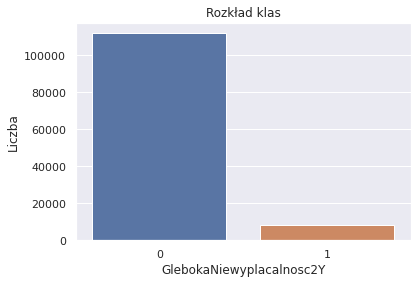

In [4]:
positives = sum(df["GlebokaNiewyplacalnosc2Y"] == 1)
negatives = sum(df["GlebokaNiewyplacalnosc2Y"] == 0)
print(f"Kategoria pozytywna: {positives} | {round(positives/df.shape[0]*100,2)}% wszystkich instancji")
print(f"Kategoria negatywna: {negatives} | {round(negatives/df.shape[0]*100,2)}% wszystkich instancji")
plt.figure(figsize=(6,4))
sns.countplot(df["GlebokaNiewyplacalnosc2Y"])
plt.ylabel("Liczba")
plt.title("Rozkład klas")
plt.show()

<h4>Przyjrzyjmy się korelacji cech</h4>

Istnieje duża korelacja pozytywna pomiędzy liczbami opóźnień w spłatach oraz pomiędzy liczbą produktów kredytowych a liczbą hipotek (co jest faktem oczywistym). Korelacja negatywna występuje pomiędzy wiekiem a liczbą osób na utrzymaniu. Ponadto korelacja pomiędzy liczbą losową a głęboką niewypłacalnością jest praktycznie zerowa, przez co możemy tę cechę zignorować (przy tak dużej ilości danych ta cecha nie powinna doprowadzić do overfittingu, jednak nie zaszkodzi ją usunąć).

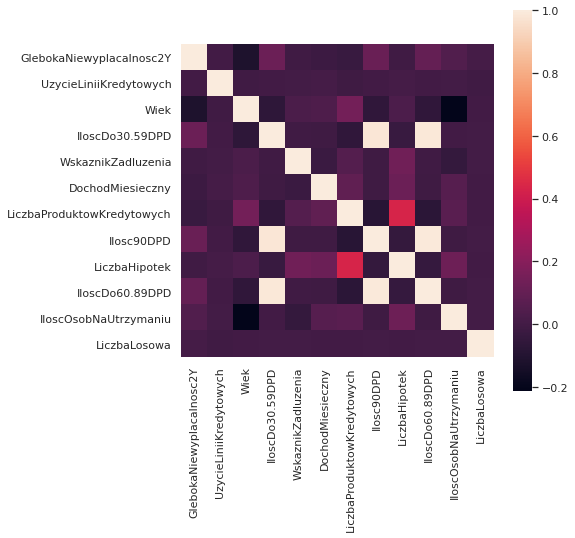

In [5]:
corr = df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, square=True)
plt.show()

In [6]:
#korelacja pomiędzy LiczbaLosowa a innymi cechami
corr['LiczbaLosowa']

GlebokaNiewyplacalnosc2Y      0.005439
UzycieLiniiKredytowych       -0.004760
Wiek                          0.000010
IloscDo30.59DPD               0.003457
WskaznikZadluzenia            0.003057
DochodMiesieczny             -0.001972
LiczbaProduktowKredytowych   -0.002345
Ilosc90DPD                    0.002824
LiczbaHipotek                -0.004366
IloscDo60.89DPD               0.002886
IloscOsobNaUtrzymaniu         0.000989
LiczbaLosowa                  1.000000
Name: LiczbaLosowa, dtype: float64

<h4>Brakujące dane</h4>

W prawie 20% przypadków nie znamy dochodu miesięcznego, a w około 2,5% przypadków nie znamy liczby osób na utrzymaniu. Jednym ze sposobów poradzenia sobie z brakującymi danymi byłoby zignorowanie instancji, w których brakuje danych. Jednak w tym przypadku wiązałoby się to z utratą znacznej ilości danych. Zastąpimy brakujące dane pewną metodą regresyjną oraz stworzymy dodatkową kolumnę, w której zaznaczymy, że w tym miejscu brakowało konkretnych danych (być może cenną informacją okaże się fakt, że brakuje na przykład miesięcznego dochodu, czego powodem mogło być chociażby ukrywanie go przez osobę ubiegającą się o kredyt).

In [7]:
#procentowy brak danych dla poszczególnych cech
missing = df.isnull().sum()/df.shape[0]
print(round(missing*100,2))

GlebokaNiewyplacalnosc2Y       0.00
UzycieLiniiKredytowych         0.00
Wiek                           0.00
IloscDo30.59DPD                0.00
WskaznikZadluzenia             0.00
DochodMiesieczny              19.84
LiczbaProduktowKredytowych     0.00
Ilosc90DPD                     0.00
LiczbaHipotek                  0.00
IloscDo60.89DPD                0.00
IloscOsobNaUtrzymaniu          2.61
LiczbaLosowa                   0.00
dtype: float64


<h4>Data preprocessing</h4>

Przygotujemy nasze dane w następującej kolejności:
- usuniemy zbędną kolumnę "LiczbaLosowa"
- stworzymy dodatkową kolumnę, w której zaznaczymy, czy brakuje jakiś informacji
- stworzymy dodatkową kolumnę, w której obliczymy dochód na jednego członka rodziny
- uzupełnimy brakujące dane IterativeImputerem (regresyjna metoda uzupełniania brakujących danych - zwiększyła AUROC walidacyjny o ponad 1.5%!)
- standaryzujemy dane przy użyciu RobustScaler'a (standaryzowanie danych nie pomogło w uzyskaniu wyższego AUROCA walidacyjnego, przez co ostatecznie z tego zrezygnowałem)

In [8]:
df_new = df.copy()

#tworzymy nową tabelę "DochodNaOsobe"
df_new['DochodNaOsobe'] = pd.Series(df_new.DochodMiesieczny/(df_new.IloscOsobNaUtrzymaniu+1))

#usuwamy zbedną kolumnę "LiczbaLosowa"
df_clean = df_new.drop(['LiczbaLosowa'], axis=1)

#tworzymy kolumnę z informacją, czy brakowało konkretnych danych
data_complete = df_clean.copy()
data_complete['Brakuje_DochodMiesieczny'] = np.where(df.DochodMiesieczny.isnull(), 1, 0)
data_complete['Brakuje_IloscOsobNaUtrzymaniu'] = np.where(df.IloscOsobNaUtrzymaniu.isnull(), 1, 0)
data_preprocessed = data_complete.copy()

<h4>Dzielimy dataset na dane uczące oraz dane walidacyjne</h4>

Zbiór danych jest stosunkowo duży (120000 rekordów), jednak mamy do czynienia ze niezbalansowanymi danymi, co oznacza, że klasa mniejszości występuje tu dużo rzadziej od klasy większości (GlebokaNiewyplacalnosc2Y przyjmuje wartość "1" dla około 6.7% rekordów). W związku z tym podzielimy dane w stosunku 80:20 (w danych walidacyjnych znajdzie się wówczas około 1600 pozytywnych klas, co pozwoli na stosunkowo dobrą generalizację).

In [9]:
data_preprocessed_array = np.array(data_preprocessed)
X = data_preprocessed_array[:,1:]
Y = data_preprocessed_array[:,0] 
X_train_raw, X_val_raw, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=120)

#uzupełniamy brakujące dane
Imputer = IterativeImputer(max_iter=100, random_state=10)
Imputer.fit(X_train_raw)
X_train = Imputer.transform(X_train_raw)
X_val = Imputer.transform(X_val_raw)

#sprawdzamy, czy w danych walidacyjnych stosunek obu klas jest zbliżony do stosunku klas w całym datasecie
print(f"{round(sum(Y_val)/Y_val.shape[0]*100,2)}%") 

6.73%


<h4>Tworzymy model XGBoost</h4>

Po przetestowaniu różnych modeli (w tym RandomForestClassifier oraz sieć neuronowa w Kerasie) model XGBoost okazał się najskuteczniejszy pod względem metryki błędu AUROC na danym datasecie. Jest on dosyć szybki i dobrze radzi sobie z niezbalansowanymi danymi. Optymalne hiperparametry naszego klasyfikatora znaleźliśmy za pomocą "grid-" oraz "random searchu".

In [10]:
#przeszukamy n klasyfikatorów XGBoost z losowo wybranymi hiperparametrami 
#z pewnego zakresu, który zawężaliśmy w oparciu o kolejne obserwacje
n = 1
best_auroc = 0 #dotychczas najwyższy AUROC
best_clf = None #model o najwyżym AUROCU

with open('record.txt', 'a') as file:
    file.write('--------\n')
    for i in range(n):
        
        learning_rate = round(random.uniform(0.04,0.07),5)
        max_depth = random.randint(4,5)
        subsample = round(random.uniform(0.65,0.75),5)
        gamma = round(random.uniform(0.06,0.09),5)
        min_child_weight = random.randint(3,5)
        
        clf = xgb.XGBClassifier(objective="binary:logistic", 
                                learning_rate = learning_rate,
                                min_child_weight = min_child_weight,
                                n_estimators = 4000,
                                gamma = gamma,
                                max_depth = max_depth,
                                subsample = subsample,
                                random_state = 100)
        
        pm = [learning_rate, max_depth, subsample, gamma, min_child_weight] #hiperparamametry w liście dla skrócenia zapisu
        print(f"Learning_rate: {pm[0]} | Max_depth: {pm[1]} | Subsample: {pm[2]} | Gamma: {pm[3]} | Min_child_weight: {pm[4]}")
        
        clf.fit(X_train, Y_train, eval_metric='auc', verbose=50,
                eval_set=[(X_val, Y_val)], early_stopping_rounds=300) #early_stopping zapobiega overfittingowi
        
        proba = clf.predict_proba(X_val)[:,1]
        AUROC = metrics.roc_auc_score(Y_val, proba)
        
        #zapisujemy do pliku hiperparametry o dotychczas najwyższym AUROCu
        if best_auroc < AUROC:
            file.write(f"Best AUROC: {AUROC} | Pms: {pm[0]}, {pm[1]}, {pm[2]}, {pm[3]}, {pm[4]}\n")
            best_auroc = AUROC
            best_clf = clf

Learning_rate: 0.06615 | Max_depth: 4 | Subsample: 0.73962 | Gamma: 0.0745 | Min_child_weight: 4


/home/olaf/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-auc:0.82835
[50]	validation_0-auc:0.86221
[100]	validation_0-auc:0.86806
[150]	validation_0-auc:0.86871
[200]	validation_0-auc:0.86891
[250]	validation_0-auc:0.86863
[300]	validation_0-auc:0.86847
[350]	validation_0-auc:0.86848
[400]	validation_0-auc:0.86857
[450]	validation_0-auc:0.86825
[500]	validation_0-auc:0.86817
[509]	validation_0-auc:0.86819


<h4>Sprawdzimy, czy model nie ma overfittingu</h4>

Model dobrze generalizuje dla danych walidacyjnych, co zauważamy po akceptowalnej różnicy wyników w metryce AUROC oraz krzywej ROC

In [11]:
proba_train = best_clf.predict_proba(X_train)[:,1]
fpr_train, tpr_train,_ = metrics.roc_curve(Y_train, proba_train)
AUROC_train = metrics.roc_auc_score(Y_train, proba_train)
proba_val = best_clf.predict_proba(X_val)[:,1]
fpr_val, tpr_val,_ = metrics.roc_curve(Y_val, proba_val)
AUROC_val = metrics.roc_auc_score(Y_val, proba_val)
print(f"AUROC dla danych uczących: {round(AUROC_train,4)}")
print(f"AUROC dla danych walidacyjnych: {round(AUROC_val,4)}")
print(f"Różnica: {round(AUROC_train - AUROC_val,4)}")

AUROC dla danych uczących: 0.8806
AUROC dla danych walidacyjnych: 0.869
Różnica: 0.0116


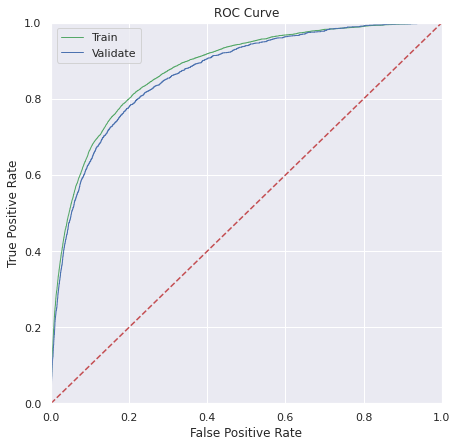

In [12]:
plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, 'g', linewidth=1, label="Train")
plt.plot(fpr_val, tpr_val, 'b', linewidth=1, label="Validate")
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

<h4>Ważność cech</h4>

Model największą wagę przykłada do wartości cechy "Ilosc90DPD", co jest bardzo intuicyjne, ponieważ dotychczasowe niewypłacalności są silnym indykatorem tego, czy osoba spłaci kolejny kredyt. Również inne opóźnienia w spłatach mają wpływ na głęboką niewypłacalność. "UzycieLiniiKredytowych" oraz "Brakuje_DochodMiesieczny" są także znaczące dla predykcji modelu.

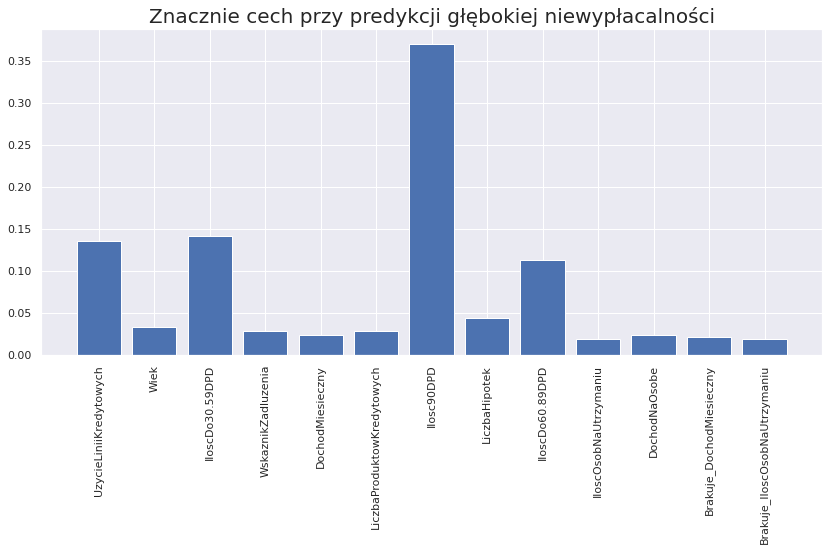

In [13]:
importance = best_clf.feature_importances_
features = data_complete.columns[1:]
plt.figure(figsize=(14,6))
plt.bar(range(len(importance)), importance, align="center")
plt.xticks(range(len(importance)), features, rotation=90)
plt.title("Znacznie cech przy predykcji głębokiej niewypłacalności", {"fontsize": 20})
plt.show()

<h4>Predykcja dla danych testowych</h4>

In [ ]:
df_test = pd.read_csv("slepy_zbior_testowy.csv", index_col="Id")

In [ ]:
ids = df_test.index.values
df_test_new = df_test.copy()
df_test_new['DochodNaOsobe'] = pd.Series(df_test_new.DochodMiesieczny/(df_test_new.IloscOsobNaUtrzymaniu+1))
df_test_clean = df_test_new.drop(['LiczbaLosowa'], axis=1)
data_test_complete = df_test_clean.copy()
data_test_complete['Brakuje_DochodMiesieczny'] = np.where(df_test.DochodMiesieczny.isnull(), 1, 0)
data_test_complete['Brakuje_IloscOsobNaUtrzymaniu'] = np.where(df_test.IloscOsobNaUtrzymaniu.isnull(), 1, 0)
data_test_preprocessed = data_test_complete.copy()
data_test_preprocessed = Imputer.transform(data_test_preprocessed)
X_test = data_test_preprocessed[:,1:]

In [ ]:
probabilities = best_clf.predict_proba(X_test)[:,1]

In [19]:
with open('Odpowiedz_Olaf_Placha.csv', 'w') as file:
    file.write('Id,P\n')
    for i in range(len(ids)):
        file.write(f"{ids[i]},{probabilities[i]}\n")

## Interpretation of model's predictions using Shap

In [17]:
import shap

In [21]:
features = list(data_preprocessed.columns.values)[1:]
explainer = shap.Explainer(best_clf, feature_names=features)
shap_values = explainer(X_val)

In [36]:
probabs = best_clf.predict_proba(X_val)

In [125]:
i = 0
print(f"Prawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[0][0]*100,2)}%.")

Prawdopodobieństwo, że osoba o id = 0 spłaci pożyczkę, to 51.21%.


Jest to stosunkowo niskie prawdopodobieństwo, przy którym bank zapewne odmówi udzielenia pożyczki z uwagi na zbyt duże ryzyko niewywiązania się z umowy przez klienta. Poniżej znajduje się wyjaśnienie decyzji modelu (są to wartości "logits" - przed zaaplikowaniem funkcji "sigmoid"). Największy wpływ na decyzję modelu miały spóźnienia w spłacie poprzednich zobowiązań.

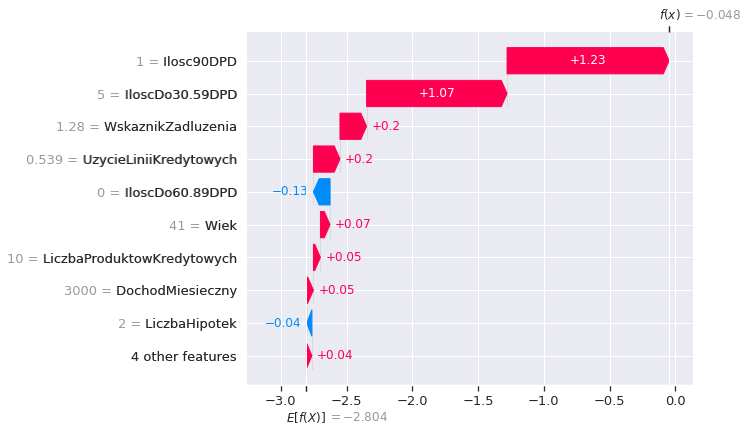

In [126]:
shap.plots.waterfall(shap_values[i])

In [193]:
i = 4668
print(f"Prawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[i][0]*100,2)}%.")

Prawdopodobieństwo, że osoba o id = 4668 spłaci pożyczkę, to 98.31%.


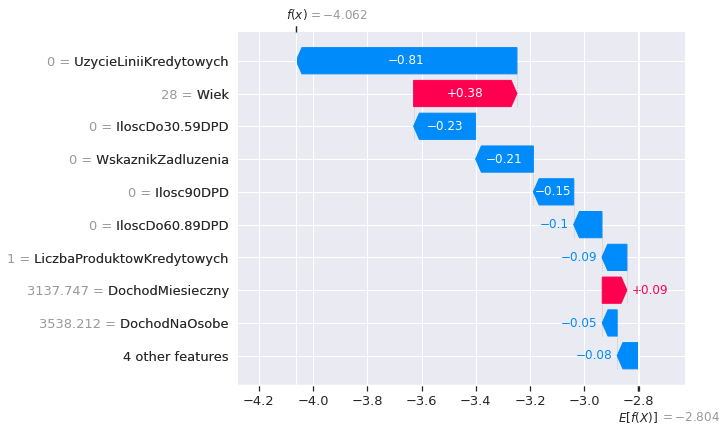

In [194]:
shap.plots.waterfall(shap_values[i])

In [225]:
i = 1729
print(f"Prawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[i][0]*100,2)}%.")

Prawdopodobieństwo, że osoba o id = 1729 spłaci pożyczkę, to 96.73%.


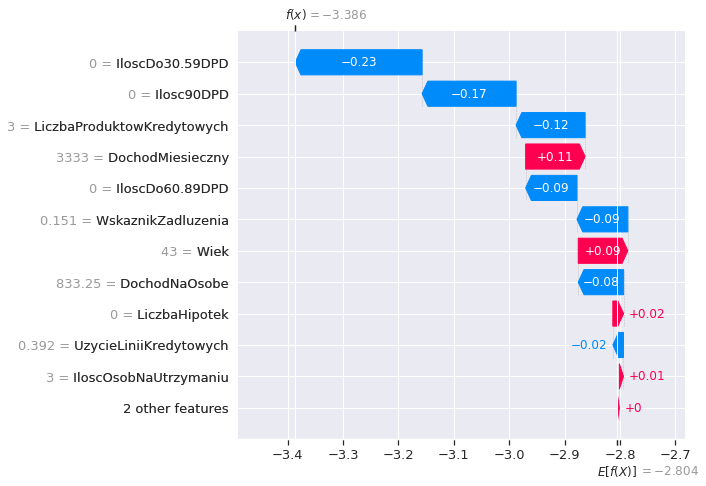

In [229]:
shap.plots.waterfall(shap_values[i], max_display=12)

Zauważmy, że u klienta o id równym 4668 prawdopodobieństwo spłaty zobowiązania jest najbardziej podniesione przez brak użycia linii kredytowych oraz najbardziej obniżone przez jego młody wiek. Natomiast u klienta o id równym 1729 to prawdopodobieństwo jest najbardziej podniesione przez brak spóźnień w spłacie poprzednich zobowiązań.

Poniżej jest przedstawiony rozkład użycia linii kredytowych u dwóch grup: tej która spłaciła zobowiązanie oraz tej która nie spłaciła zobowiązania. Łatwo zauważyć, że ta cecha jest silnym indykatorem wypłacalości. W przypadku pierwszego klienta ta cecha ma wartość 0 (bardzo mało osób z taką wartością tej cechy nie spłaciło zobowiązania), natomiast u drugiego klienta ta cecha ma wartość 0.392 i trudno na jej podstawie ocenić, czy klient spłaci swoje zobowiązanie - przez to nie miała dużego wpływu na predykcję modelu.

In [250]:
df.describe()

,GlebokaNiewyplacalnosc2Y,UzycieLiniiKredytowych,Wiek,IloscDo30.59DPD,WskaznikZadluzenia,DochodMiesieczny,LiczbaProduktowKredytowych,Ilosc90DPD,LiczbaHipotek,IloscDo60.89DPD,IloscOsobNaUtrzymaniu,LiczbaLosowa
count,120000.000000,120000.000000,120000.000000,120000.000000,120000.000000,9.619200e+04,120000.000000,120000.000000,120000.000000,120000.000000,116867.000000,1.200000e+05
mean,0.066775,5.866244,52.320333,0.426050,348.231903,6.683413e+03,8.458050,0.272292,1.017950,0.246233,0.755055,3.999372e-01
std,0.249633,251.854696,14.780087,4.256148,1740.189692,1.538419e+04,5.146273,4.233493,1.134624,4.219860,1.112055,2.304956e-01
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,4.353933e-07
25%,0.000000,0.029752,41.000000,0.000000,0.174629,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000,2.006630e-01
50%,0.000000,0.154296,52.000000,0.000000,0.365923,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000,3.989501e-01
75%,0.000000,0.559389,63.000000,0.000000,0.867086,8.250000e+03,11.000000,0.000000,2.000000,0.000000,1.000000,5.992965e-01
max,1.000000,50708.000000,105.000000,98.000000,307001.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,10.000000,8.005129e-01


In [256]:
df_paid_back = df.loc[df['GlebokaNiewyplacalnosc2Y']==0]
df_not_paid_back = df.loc[df['GlebokaNiewyplacalnosc2Y']==1]

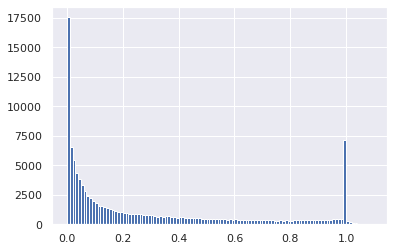

In [257]:
plt.hist(df_paid_back["UzycieLiniiKredytowych"], bins=[0.01*x for x in range(110)])
plt.show()

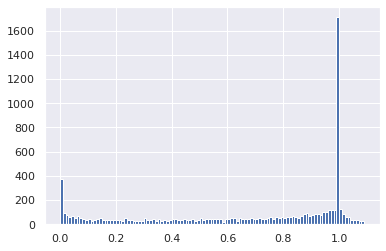

In [258]:
plt.hist(df_not_paid_back["UzycieLiniiKredytowych"], bins=[0.01*x for x in range(110)])
plt.show()

In [259]:
i = 1000
print(f"Prawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[i][0]*100,2)}%.")

Prawdopodobieństwo, że osoba o id = 1000 spłaci pożyczkę, to 99.28%.


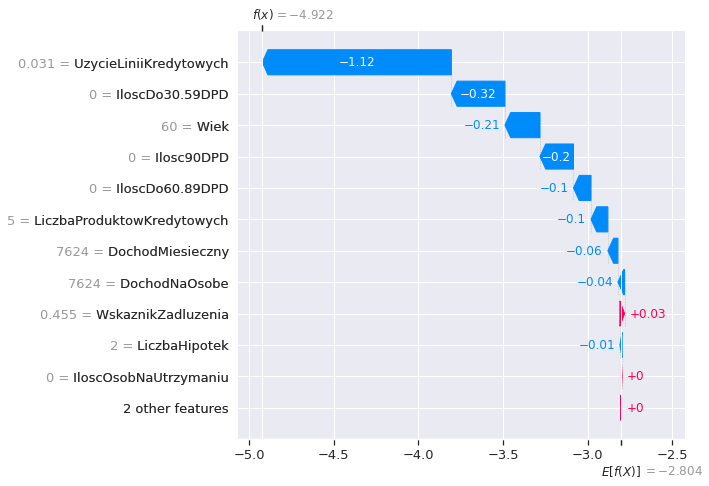

In [260]:
shap.plots.waterfall(shap_values[i], max_display=12)

Porównajmy wpływ wieku na predykcję modelu. W przypadku osoby o id równym 4668 wiek (28 lat) miał negatywny wpływ na jego ocenę wypłacalności. Natomiast dla osoby o id równym 1000 wiek (60 lat) miał pozytywny wpływ. Można to wytłumaczyć dwoma poniższymi wykresami: wśród osób w podeszłym wieku stosunek spłaconych do niespłaconych zobowiązań jest większy niż w przypadku osób młodocianych.

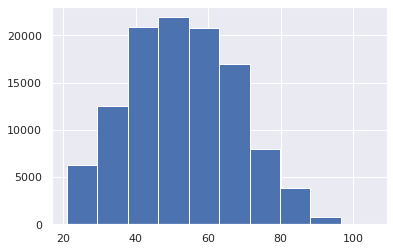

In [267]:
plt.hist(df_paid_back["Wiek"], bins=10)
plt.show()

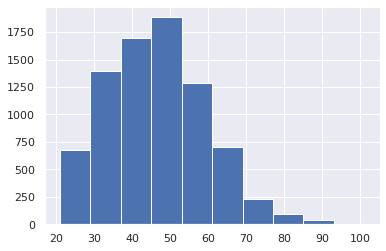

In [268]:
plt.hist(df_not_paid_back["Wiek"], bins=10)
plt.show()

Teraz porównamy interpretacje naszego modelu z innym modelem. W tym celu wytrenujemy las losowy.

In [240]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [122]:
explainer = shap.Explainer(clf, feature_names=features)
shap_values = explainer(X_val)

In [126]:
X_val_df = pd.DataFrame(data=X_val, columns=features) 

In [129]:
choosen_instance = X_val_df.iloc[[4668]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], choosen_instance)

Zauważmy, że dla klienta o id równym 4668 oba modele dały podobne prawdopodobieństwo spłacenia pożyczki: około 95%. W przypadku pierwszego modelu liczba produktów kredytowych równa 1 zwiększała szansę na spłatę pożyczki, natomiast w drugim modelu ta wartość cechy zmniejsza szansę na wywiązanie się przez klienta z zobowiązania. 

## Interpretation of model's predictions using LIME

Uwaga! Czerwone słupki kontrybuują to pozytywnej oceny klienta

In [22]:
import lime
import lime.lime_tabular

In [25]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                    feature_names=features, 
                    class_names=['spłaci', 'nie spłaci'],                            
                    verbose=True, mode='regression')

Intercept 0.27482735868384844
Prediction_local [0.06480544]
Right: 0.0

Prawdopodobieństwo, że osoba o id = 10 spłaci pożyczkę, to 82.86%.
Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME


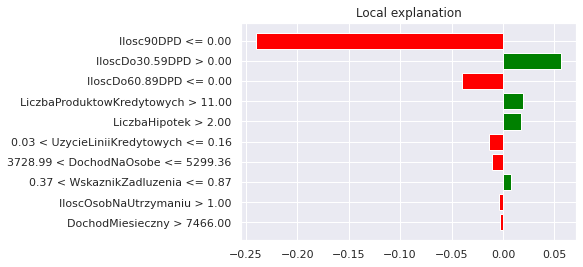

In [60]:
i = 10
exp = explainer.explain_instance(X_val[i], best_clf.predict, num_features=10)
exp.as_pyplot_figure()
print(f"\nPrawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[i][0]*100,2)}%.")
print("Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME")

Intercept 0.2774299166323782
Prediction_local [0.13762044]
Right: 0.0

Prawdopodobieństwo, że osoba o id = 40 spłaci pożyczkę, to 65.37%.
Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME


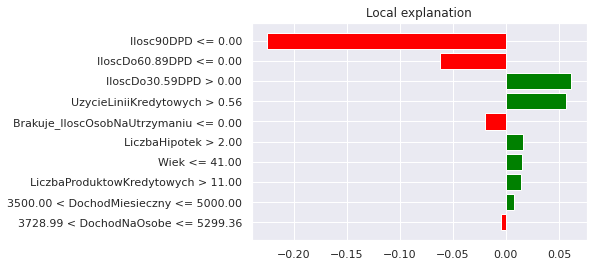

In [62]:
i = 40
exp = explainer.explain_instance(X_val[i], best_clf.predict, num_features=10)
exp.as_pyplot_figure()
print(f"\nPrawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabs[i][0]*100,2)}%.")
print("Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME")

Dla klienta o id równym 10 największy (w tym przypadku pozytywny) wpływ na decyzję modelu miał brak spóźnień w spłatach zobowiązań powyżej 90 dni. Drugą ważną informacją (tym razem nagatywnie wpływającą na ocenę klienta) miała dodatnia liczba spóźnień w spłatach zobowiązań od 30 do 59 dni.

Natomiast dla klienta o id równym 40 można zauważyć podobne istotności wyżej wymienionych cech, gdzie brak poprzednich opóźnień w spłatach polepsza ocenę klienta.

Te dwa przykłady sugerują, że metoda LIME jest stabilna.

In [17]:
from sklearn.neural_network import MLPClassifier

In [18]:
mlp_clf = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(50, 20), max_iter=1000, random_state=1)
mlp_clf.fit(X_train, Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(50, 20), max_iter=1000,
              random_state=1)

In [168]:
probabsMLP = clf.predict_proba(X_val)

Intercept -0.005896913864083492
Prediction_local [0.00725716]
Right: 0.0

Prawdopodobieństwo, że osoba o id = 10 spłaci pożyczkę, to 77.58%.
Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME


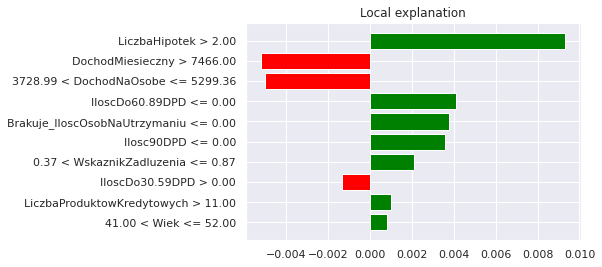

In [96]:
i = 10
exp = explainer.explain_instance(X_val[i], clf.predict, num_features=10)
exp.as_pyplot_figure()
print(f"\nPrawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(probabsMLP[i][0]*100,2)}%.")
print("Poniżej znajduje się wytłumaczenie decyzji modelu metodą LIME")

W przypadku prostej sieci neuronowej dla klienta o id równym 10 ponad dwie zaciągnięte hipoteki miały największy negatywny wpływ na ocenę klienta, który był rekompensowany przed duży miesięczny dochód. Zatem kontrybucja cech w tym klasyfikatorze jest inna niż w przypadku XGBoosta, jednak w obu przypadkach prawdopodobieństwo spłaty pożyczki oscyluje w okolicy 80%. 

## Interpretation of model's predictions using ICE plots

Prawdopodobieństwo, że osoba o id równym o spłaci pożyczkę wynosi około 51%. Dzięki profilowi CP widzimy, jak lokalnie zachowuje się model dla tego klienta. Poniżej znajdują się wykresy pokazujące zachowanie modelu dla kilku cech.

![](pd/pd1.png)

![](pd/pd2.png)

![](pd/pd3.png)

Najbardziej oczywistym zachowaniem modelu jest rosnąca szansa na niespłacenie pożyczki w przypadku opóźnień w poprzednich spłatach. Widzimy to na ostatnim wykresie.

Porównajmy teraz zachowanie dla klienta o id równym 0 z klientem o id równym 42. Zauważmy, że w przypadku drugiego klienta szansa na niespłacenie pożyczki maleje monotonicznie w wiekiem (poniższy wykres). Natomiast w przypadku pierwszego klienta zauważamy wzrost tej szansy w okolicach 80 r.ż. <br/><br/> Przypomnijmy, że pierwszy klient miał łącznie 6 spóźnień w spłatach, natomiast drugi klient nie miał żadnych zaległości. Jest to największa różnica pomiędzy tymi klientami. <br/><br/> Skąd zatem różnica w przebiegu wykresów dla wieku powyżej 80 r.ż.? Być może wynika to z tego, że jeżeli osoba w podeszłym wieku nie miała spóźnień w spłacie zobowiązań przez 80 lat, to również nie będzie ich miała w późniejszym wieku. Natomiast jeżeli pojawiły się wcześniej jakieś spóźnienia (które być może wynikały z zapomnienia o kolejnej racie), to po 80 r.ż. szansa na kolejne spóźnienia rośnie (być może z powodu nasilających się problemów z pamięcią).

![](pd/pd4.png)

Poniżej znajduje się wykres ICE sieci neuronowej dla klienta o id równym 0. Przebieg tego wykresu jest nieznacznie inny niż dla XGBoost'a. Zauważamy, że gdyby ten klient był w wieku 70 lat, to szansa na spłatę zobowiązania (według modelu) byłaby nieznacznie wyższa niż gdyby był w wieku 80 lat. Taka sytuacja nie ma miejsca w interpretacji modelu XGBoost. Prawdopodobnie jest to szum.

![](pd/pd5.png)

### Appendix
Code for reproducing above results

In [14]:
from ceteris_paribus.profiles import individual_variable_profile
from ceteris_paribus.plots.plots import plot
from ceteris_paribus.explainer import explain

In [15]:
X_val_df = pd.DataFrame(X_val, columns=features)
X_val_df['UzycieLiniiKredytowych'] = X_val_df['UzycieLiniiKredytowych'].apply(lambda x: min(x, 1))
X_val_df['Ilosc90DPD'] = X_val_df['Ilosc90DPD'].apply(lambda x: min(x, 5))
X_val_df['DochodMiesieczny'] = X_val_df['DochodMiesieczny'].apply(lambda x: max(x, 0))

In [160]:
# pokażmy predykcję modelu dla przykładu
i = 0
print(f"Prawdopodobieństwo, że osoba o id = {i} spłaci pożyczkę, to {round(proba_val[i]*100,2)}%.")

Prawdopodobieństwo, że osoba o id = 0 spłaci pożyczkę, to 51.13%.


In [235]:
explainer_xgb = explain(best_clf, data=X_val_df, y=Y_val, label='XGBoost',
    predict_function=lambda X: best_clf.predict_proba(X)[:, 1])

In [236]:
cp_xgb = individual_variable_profile(explainer_xgb, X_val_df.iloc[i], Y_val[i])
plot(cp_xgb, selected_variables=["UzycieLiniiKredytowych"])
plot(cp_xgb, selected_variables=["Wiek"])
plot(cp_xgb, selected_variables=["Ilosc90DPD"])

In [204]:
j = 42
cp_xgb = individual_variable_profile(explainer_xgb, X_val_df.iloc[j], Y_val[j])
plot(cp_xgb, selected_variables=["Wiek"])

In [21]:
# explaining MLP Classifier
explainer_mlp = explain(mlp_clf, data=X_val_df, y=Y_val, label='XGBoost',
    predict_function=lambda X: best_clf.predict_proba(X)[:, 1])

In [30]:
i = 0
cp_xgb = individual_variable_profile(explainer_mlp, X_val_df.iloc[i], Y_val[i])

In [31]:
plot(cp_xgb, selected_variables=["Wiek"])